In [63]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

In [64]:
csv_files = [k for k in os.listdir() if k.endswith(".csv")]

In [65]:
err_df = []
for k in csv_files:
    try:
        df = pd.read_csv(k, sep = ";",header=None)
        #print(df.columns.__len__())
        if df.columns.__len__() != 301:
            print(f"check cols in {k}")
            err_df.append(k)
    except:
        print(k)
print(f"err df: {err_df}")

analisys_pore_data_10013.csv
analisys_pore_data_28.csv
analisys_pore_data_13.csv
analisys_pore_data_32.csv
err df: []


In [66]:
dfs = []

for k in csv_files:
    try:
        df = pd.read_csv(k, sep = ";", header=None)
        number = k[k.rfind("_") + 1:k.rfind(".")]
        if len(number):
            number = number[-3:]
        df["Rock ID"] = number
        dfs.append(df)
    except:
        print(k)

analisys_pore_data_10013.csv
analisys_pore_data_28.csv
analisys_pore_data_13.csv
analisys_pore_data_32.csv


In [67]:
data = pd.concat(dfs, ignore_index=True)

In [68]:
data["Rock ID"] = data["Rock ID"].astype(int).astype(str)

In [69]:
data.isna().sum().value_counts()

1        282
0         17
4          1
362        1
40045      1
Name: count, dtype: int64

In [70]:
data = data.drop(columns=[300])
data.shape

(40045, 301)

In [71]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.to_list()

In [72]:
ren_dict = {}
for k in numeric_cols:
    ren_dict[k] = str(k)

In [73]:
data=data.rename(ren_dict)

In [74]:
data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], np.nan)

In [75]:
imputer = SimpleImputer(strategy="mean")
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

In [76]:
columns_to_drop = []
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        zero_ratio = (data[col] == 0).mean()
        if zero_ratio > 0.5:
            columns_to_drop.append(col)
            
columns_to_drop.__len__()

164

In [77]:
data.drop(columns=columns_to_drop, inplace=True)

In [78]:
map_dict = {'10': "Кальциевый", 
 '02': "Чистый уратный", 
 '11': "", 
 '12': "", 
 '16': "Кальциевый", 
 '18': "Кальциевый",
 '19': "", 
 '25': "Кальциевый", 
 '27': "", 
 '28': "Уратный + кальций", 
 '30': "",
'31': "Кальциевый", 
'32': "Уратный + кальций", 
'33': "Чистый уратный", 
'34': "Кальциевый", 
'36': "Цистиновый", 
'37': "", 
'40': "", 
'43': "Кальциевый", 
'50': "Кальциевый", 
'51': "", 
'52': "Кальциевый",
'82': "", 
'53': "", 
'55': "", 
'2': "Чистый уратный", 
'9': "Кальциевый",
"153": "Цистиновый",
"155": "Уратный + кальций"}

In [79]:
map_dict = {'10': "", 
 '02': "Pure uric acid", 
 '11': "", 
 '12': "", 
 '16': "Calcium", 
 '18': "Calcium", 
 '19': "", 
 '25': "Calcium", 
 '27': "", 
 '28': "Uric acid with calcium", 
 '30': "",
'31': "Calcium", 
'32': "Uric acid with calcium", 
'33': "Pure uric acid", 
'34': "Calcium", 
'36': "Cystine", 
'37': "", 
'40': "", 
'43': "Calcium", 
'50': "Calcium", 
'51': "", 
'52': "Calcium",
'82': "", 
'53': "", 
'55': "", 
'2': "Pure uric acid", 
'9': "Calcium",
"155": "Uric acid with calcium",
"153": "Cystine"}

In [80]:
data["type"] = data["Rock ID"].map(map_dict)

/tmp/ipykernel_194673/1901726674.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["type"] = data["Rock ID"].map(map_dict)


In [81]:
data["type"].value_counts()

type
                          14898
Calcium                   12286
Pure uric acid             3822
Uric acid with calcium     3285
Cystine                    1832
Name: count, dtype: int64

In [82]:
data.shape

(40045, 138)

In [83]:
data["type"] = data["type"].astype(str)

In [84]:
# Создаем список значений для удаления
to_remove = ["", "","Cystine", "nan"]

# Фильтруем данные
data = data[~data["type"].isin(to_remove) & data["type"].notna()]

In [85]:
data_learning = data.copy()

In [86]:


# 1. Получение уникальных ID камней с их типами
unique_rocks = data_learning[['Rock ID', 'type']].drop_duplicates()

# 2. Стратифицированное разделение с гарантией всех типов в тесте
train_ids = pd.Series(dtype='object')
test_ids = pd.Series(dtype='object')

# Для каждого типа камней разделяем отдельно
for stone_type in unique_rocks['type'].unique():
    type_subset = unique_rocks[unique_rocks['type'] == stone_type]
    
    # Вычисляем размер тестовой выборки для типа (минимум 1 образец)
    n = len(type_subset)
    n_test = max(1, int(0.2 * n))  # Гарантируем хотя бы 1 образец
    
    # Разделение для текущего типа
    type_train, type_test = train_test_split(
        type_subset['Rock ID'],
        test_size=n_test,
        random_state=42
    )
    
    train_ids = pd.concat([train_ids, type_train])
    test_ids = pd.concat([test_ids, type_test])

# 3. Создание итоговых выборок
train_data = data_learning[data_learning['Rock ID'].isin(train_ids)]
test_data = data_learning[data_learning['Rock ID'].isin(test_ids)]

# 4. Проверка распределения
print("Train распределение:")
print(train_data['type'].value_counts(normalize=True))
print("\nTest распределение:")
print(test_data['type'].value_counts(normalize=True))

Train распределение:
type
Calcium                   0.703699
Pure uric acid            0.149784
Uric acid with calcium    0.146517
Name: proportion, dtype: float64

Test распределение:
type
Pure uric acid            0.373992
Calcium                   0.371058
Uric acid with calcium    0.254950
Name: proportion, dtype: float64


In [87]:
X_train = train_data.drop(columns = ['Rock ID', "type"], axis=1)
#y = train_data[['type', 'Rock ID']]
y_trian= train_data["type"]
le = LabelEncoder()
y_train_encoded= le.fit_transform(y_trian)
X_test = test_data.drop(columns = ['Rock ID', "type"], axis=1)

y_test= test_data["type"]
y_test_encoded= le.fit_transform(y_test)

In [88]:
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)


In [89]:
import matplotlib.patches as mpatches

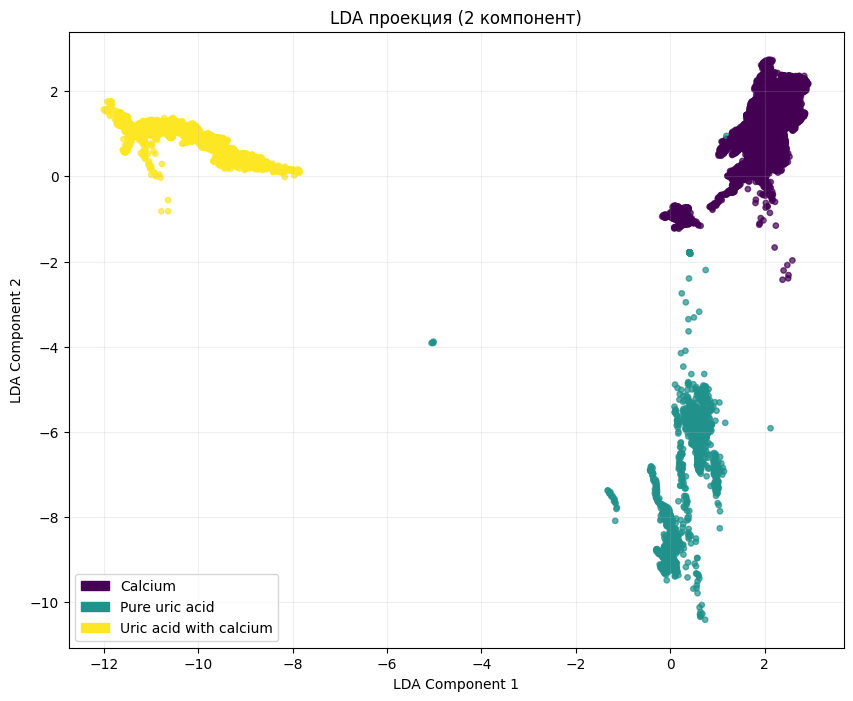

In [90]:


# Определение числа компонент
n_components = min(len(le.classes_) - 1, X_scaled.shape[1])

if n_components > 0:
    # Создание LDA модели
    lda = LinearDiscriminantAnalysis(n_components=n_components, solver="eigen", shrinkage=0.7)
    X_lda = lda.fit_transform(X_scaled, y_train_encoded)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    
    if n_components == 1:
        # Для 1 компоненты используем точечный график
        plt.scatter(X_lda, np.zeros_like(X_lda), c=y_train_encoded, cmap='viridis', alpha=0.7, s=15)
        plt.yticks([])
    else:
        # Для 2+ компонент
        scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_train_encoded, cmap='viridis', alpha=0.7, s=15)
    
    plt.title(f'LDA проекция ({n_components} компонент)')
    plt.xlabel('LDA Component 1')
    if n_components > 1:
        plt.ylabel('LDA Component 2')
    
    # Создание легенды
    patches = [mpatches.Patch(color=plt.cm.viridis(i/(len(le.classes_)-1)), label=name) for i, name in enumerate(le.classes_)]
    plt.legend(handles=patches)
    plt.grid(alpha=0.2)
    plt.show()
else:
    print("LDA требует как минимум 2 класса для визуализации")

In [99]:
X_scaled

array([[-0.84292725, -0.93835516,  0.5228483 , ..., -0.27801566,
        -0.35462261, -0.28416101],
       [-0.83876702, -0.9408943 ,  0.51556023, ..., -0.2599933 ,
        -0.35517981, -0.2834996 ],
       [-0.83439218, -0.94152909,  0.52527766, ..., -0.25894852,
        -0.35601561, -0.28383031],
       ...,
       [-0.0805033 , -0.00696694,  0.36008132, ..., -0.20383665,
        -0.33024508, -0.27242095],
       [-0.08628552, -0.02545505,  0.34429049, ..., -0.22238141,
        -0.32676258, -0.27291701],
       [-0.09084197, -0.03577031,  0.33943178, ..., -0.21323963,
        -0.32787698, -0.27175953]], shape=(15302, 136))

In [100]:
X_lda

array([[1.7825908 , 1.33138388],
       [1.7810554 , 1.33229012],
       [1.87300637, 1.40037721],
       ...,
       [1.7105546 , 0.75544879],
       [1.71389519, 0.78824448],
       [1.70126438, 0.77182204]], shape=(15302, 2))

In [32]:
y_train_encoded

array([0, 0, 0, ..., 0, 0, 0], shape=(15302,))

In [33]:
y_encoded = le.transform(y_trian)

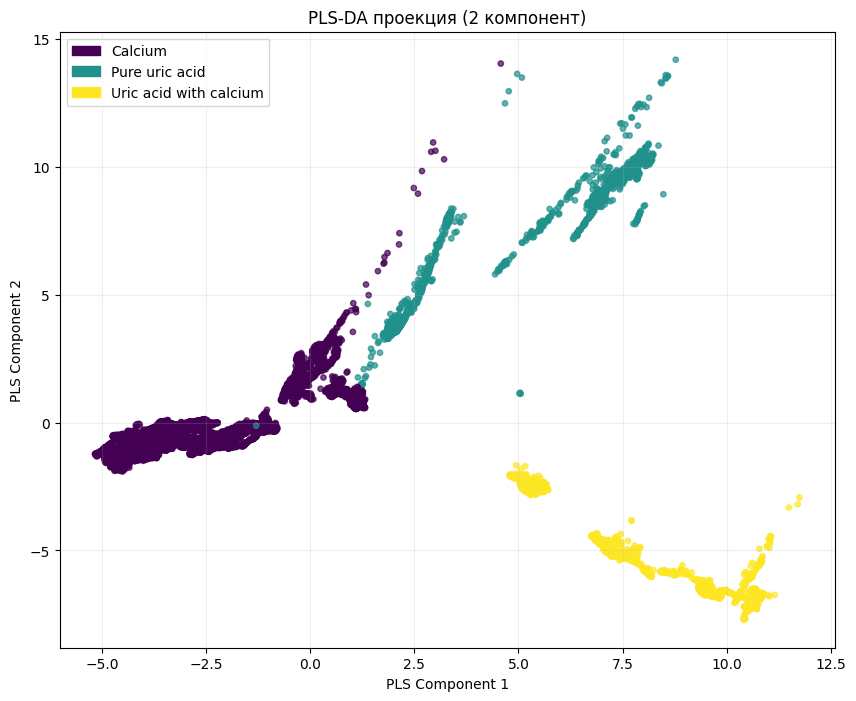

In [35]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelBinarizer

# Преобразуем метки классов в one-hot формат
lb = LabelBinarizer()
y_onehot = lb.fit_transform(y_train_encoded)

# Определяем число компонент (минимум из числа классов-1 и признаков)
n_components = min(len(le.classes_) - 1, X_scaled.shape[1])

if n_components > 0:
    # Создаем и обучаем PLS модель
    pls = PLSRegression(n_components=n_components)
    X_pls = pls.fit_transform(X_scaled, y_onehot)[0]  # Берем только X-компоненты

    # Визуализация
    plt.figure(figsize=(10, 8))
    
    if n_components == 1:
        plt.scatter(X_pls[:, 0], np.zeros_like(X_pls[:, 0]), c=y_encoded, cmap='viridis', alpha=0.7, s=15)
        plt.yticks([])
    else:
        plt.scatter(X_pls[:, 0], X_pls[:, 1], c=y_encoded, cmap='viridis', alpha=0.7, s=15)
    
    plt.title(f'PLS-DA проекция ({n_components} компонент)')
    plt.xlabel('PLS Component 1')
    if n_components > 1:
        plt.ylabel('PLS Component 2')
    
    # Создание легенды
    patches = [mpatches.Patch(color=plt.cm.viridis(i/(len(le.classes_)-1)), label=name) for i, name in enumerate(le.classes_)]
    plt.legend(handles=patches)
    plt.grid(alpha=0.2)
    plt.show()
else:
    print("PLS-DA требует как минимум 2 класса для визуализации")

In [36]:
X_scaled

array([[-0.84292725, -0.93835516,  0.5228483 , ..., -0.27801566,
        -0.35462261, -0.28416101],
       [-0.83876702, -0.9408943 ,  0.51556023, ..., -0.2599933 ,
        -0.35517981, -0.2834996 ],
       [-0.83439218, -0.94152909,  0.52527766, ..., -0.25894852,
        -0.35601561, -0.28383031],
       ...,
       [-0.0805033 , -0.00696694,  0.36008132, ..., -0.20383665,
        -0.33024508, -0.27242095],
       [-0.08628552, -0.02545505,  0.34429049, ..., -0.22238141,
        -0.32676258, -0.27291701],
       [-0.09084197, -0.03577031,  0.33943178, ..., -0.21323963,
        -0.32787698, -0.27175953]], shape=(15302, 136))

In [37]:
X_lda

array([[1.7825908 , 1.33138388],
       [1.7810554 , 1.33229012],
       [1.87300637, 1.40037721],
       ...,
       [1.7105546 , 0.75544879],
       [1.71389519, 0.78824448],
       [1.70126438, 0.77182204]], shape=(15302, 2))

In [38]:
X_pls

array([[-1.54971184, -0.20220928],
       [-1.54626609, -0.19026851],
       [-1.59337984, -0.16020709],
       ...,
       [-2.52142495, -0.25362165],
       [-2.51946868, -0.26943773],
       [-2.50887288, -0.26909993]], shape=(15302, 2))

In [39]:
X_test_scaled = scaler.transform(X_test)  # Масштабирование

In [40]:
X_test_lda = lda.transform(X_test_scaled)
X_test_lda

array([[-6.99495008,  0.6079963 ],
       [-6.98058598,  0.60215257],
       [-6.95458488,  0.59089196],
       ...,
       [ 3.8287591 ,  1.96567313],
       [ 3.81663715,  1.92173441],
       [ 3.81294632,  1.78266542]], shape=(4091, 2))

In [41]:
X_test_pls = pls.transform(X_test_scaled)
X_test_pls

array([[ 5.8810499 , -3.93379935],
       [ 5.88266757, -3.91915913],
       [ 5.87558436, -3.90366111],
       ...,
       [-1.88700329,  0.68431137],
       [-1.8516147 ,  0.73015589],
       [-1.72392721,  0.97286109]], shape=(4091, 2))

In [42]:
y_test_encoded

array([2, 2, 2, ..., 0, 0, 0], shape=(4091,))

In [43]:
y = train_data["type"].astype(str)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_lda, y, test_size=0.2, random_state=42)

In [45]:
#X_train, X_val, y_train, y_val = train_test_split(X_pls, y, test_size=0.2, random_state=42)

In [46]:
X_train.shape

(12241, 2)

In [47]:
y_train_encoded = le.transform(y_train)
y_train_encoded 

array([2, 0, 0, ..., 0, 1, 0], shape=(12241,))

In [48]:
le.classes_

array(['Calcium', 'Pure uric acid', 'Uric acid with calcium'],
      dtype=object)

In [49]:
def plot_scatter(X_train, y_train_encoded, le = le):    

    class_names = le.classes_
    
    num = len(class_names)

    plt.figure(figsize=(12, 10))

    # Создаем палитру цветов для классов
    colors = ["#F83306", '#3399FF', '#33CC33', '#CC33FF'][:num]  # Оранжевый, Синий, Зеленый, Фиолетовый

    # Создаем словарь для названий классов
    class_dict = {i: name for i, name in enumerate(class_names)}

    # Рисуем каждый класс отдельно
    for class_idx in range(len(class_names)):
        # Выбираем только точки текущего класса
        mask = (y_train_encoded == class_idx)
        
        plt.scatter(
            X_train[mask, 0],
            X_train[mask, 1],
            c=colors[class_idx],
            label=class_dict[class_idx],
            alpha=0.8,
            s=60,
            edgecolor='w',
            linewidth=0.5
        )

    # Добавляем легенду с названиями классов
    plt.legend(title='Тип камней', title_fontsize=12, fontsize=11, loc='best', frameon=True, shadow=True)

    # Настраиваем оформление
    plt.title('Визуализация состава камней после LDA', fontsize=14, pad=20)
    plt.xlabel('Главная компонента 1', fontsize=12)
    plt.ylabel('Главная компонента 2', fontsize=12)
    plt.grid(alpha=0.2, linestyle='--')

    # Добавляем информационный текст
    plt.figtext(0.5, 0.01, 'Анализ состава камней', ha='center', fontsize=9, alpha=0.7)

    plt.tight_layout()
    plt.show()

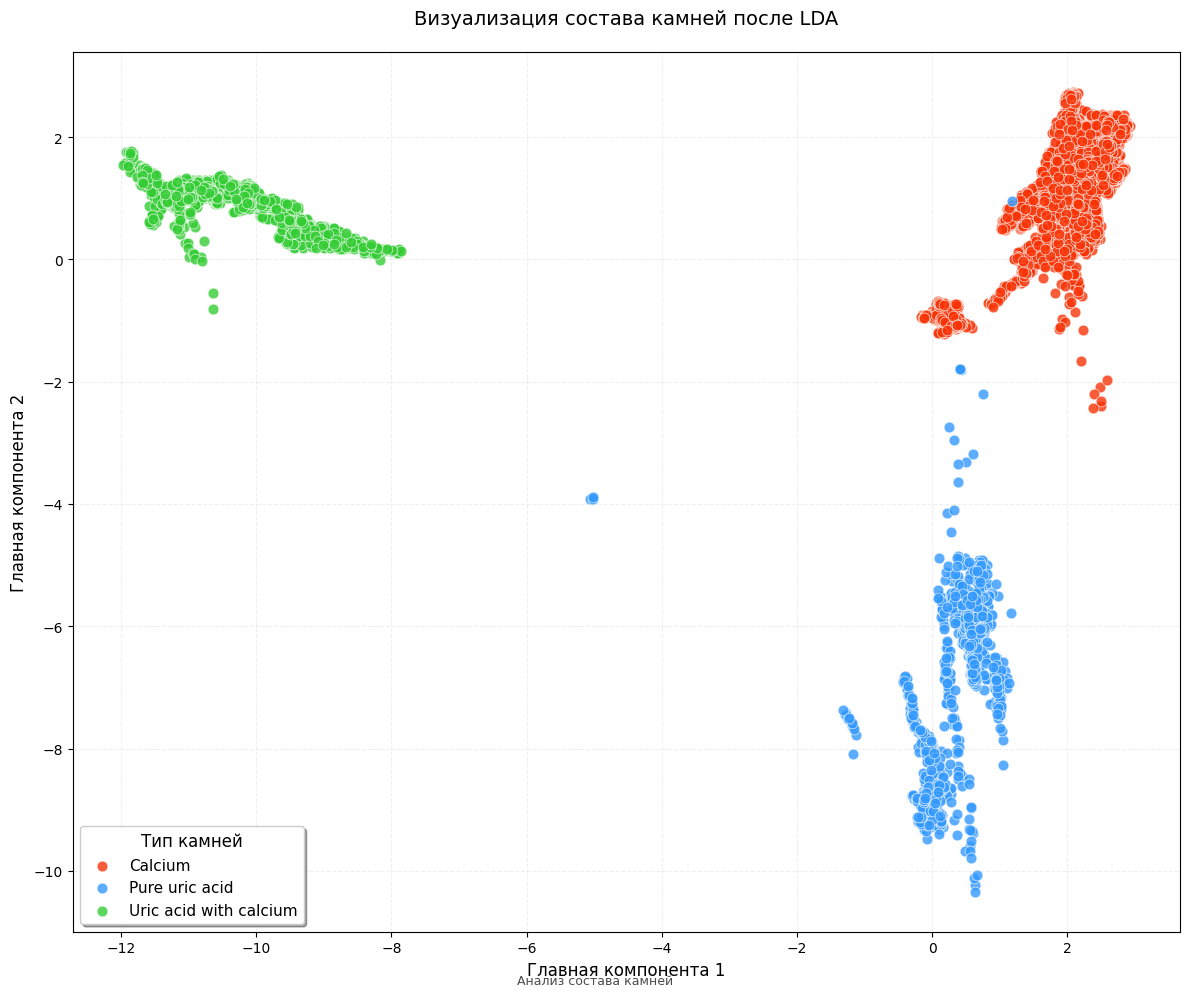

In [50]:
plot_scatter(X_train, y_train_encoded, le = le)

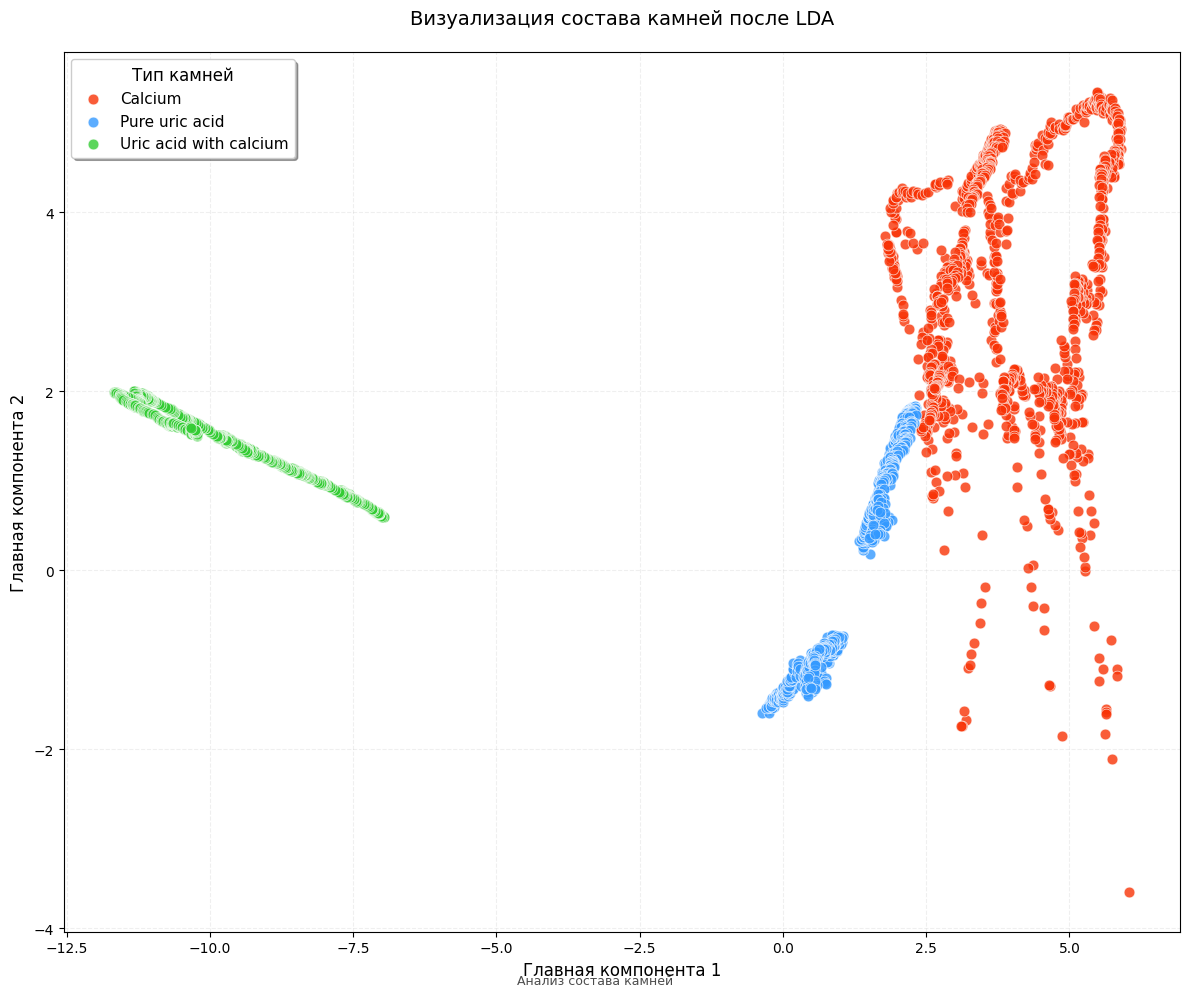

In [51]:
plot_scatter(X_test_lda, y_test_encoded, le = le)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

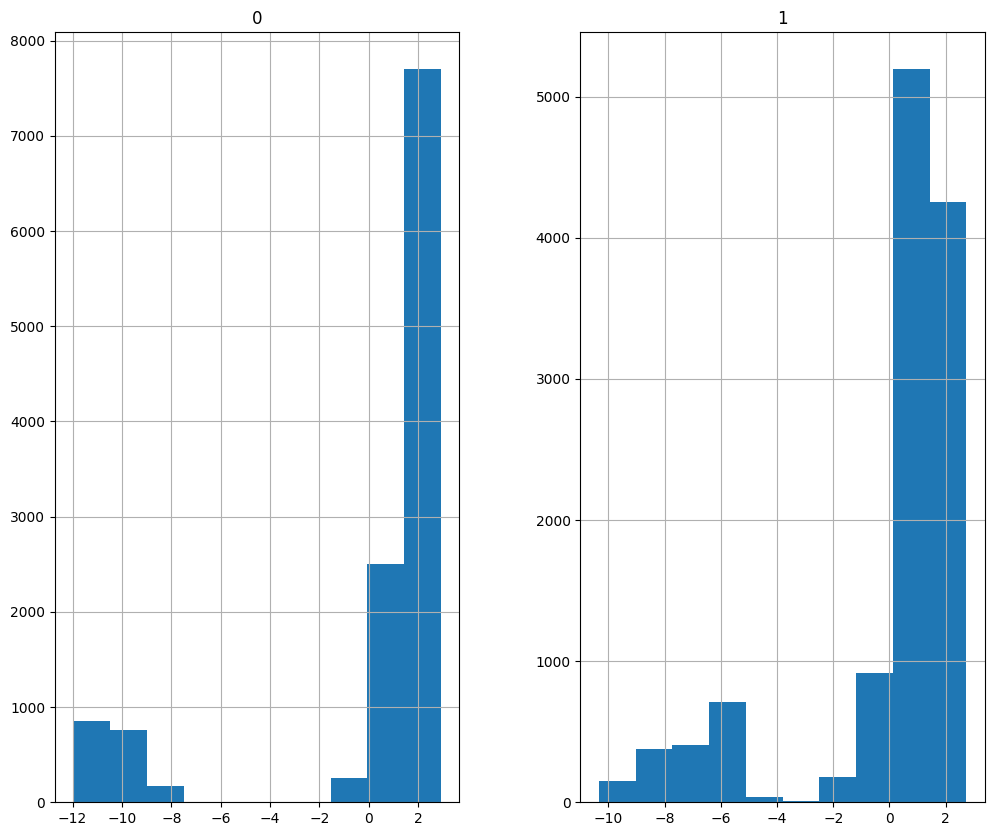

In [52]:
X_train_df = pd.DataFrame(X_train)
X_train_df.hist(figsize=(12,10))

In [53]:
log_reg = LogisticRegression(max_iter=5000,class_weight="balanced",C = np.float64(0.0001), l1_ratio = 0.1, penalty = 'elasticnet', solver = 'saga')
log_reg.fit(X_train, y_train_encoded)


LogisticRegression(C=np.float64(0.0001), class_weight='balanced', l1_ratio=0.1,
                   max_iter=5000, penalty='elasticnet', solver='saga')

In [54]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

In [55]:
X_train

array([[-10.07885832,   1.19414882],
       [  2.45746097,   1.67767062],
       [  2.56838889,   1.76082461],
       ...,
       [  2.23246299,   1.5533396 ],
       [ -0.2031991 ,  -9.12763861],
       [  2.03156664,   1.47407129]], shape=(12241, 2))

In [56]:
y_train_encoded

array([2, 0, 0, ..., 0, 1, 0], shape=(12241,))

In [57]:
X_test_lda

array([[-6.99495008,  0.6079963 ],
       [-6.98058598,  0.60215257],
       [-6.95458488,  0.59089196],
       ...,
       [ 3.8287591 ,  1.96567313],
       [ 3.81663715,  1.92173441],
       [ 3.81294632,  1.78266542]], shape=(4091, 2))

In [58]:
y_test_encoded

array([2, 2, 2, ..., 0, 0, 0], shape=(4091,))

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_encoded)
weights = compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train_encoded
)
class_weights = dict(zip(classes, weights))
class_weights


{np.int64(0): np.float64(0.47423678909034556),
 np.int64(1): np.float64(2.1913712853562477),
 np.int64(2): np.float64(2.2987793427230048)}

In [61]:
print("Train class distribution:", np.bincount(y_train_encoded))
print("Test class distribution:", np.bincount(y_test_encoded))

Train class distribution: [8604 1862 1775]
Test class distribution: [1518 1530 1043]


In [62]:

# SVM
# Случайный лес
rf = RandomForestClassifier(random_state=42, class_weight="balanced", criterion='gini', n_jobs=-1)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False]
}

log_reg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",)

log_reg_params = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2', 'elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.9]  # Только для elasticnet
}

svm = SVC(
    kernel='rbf', 
    class_weight='balanced', 
    probability=True,  # Для получения вероятностей
    random_state=42
)

svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf', 'linear'],
    'degree': [2, 3, 4]  # Для полиномиального ядра
}

# Decision Tree
dt = DecisionTreeClassifier(
    random_state=42, 
 # Автоматическая балансировка классов
    class_weight=class_weights
    
)

# 2. Задаем сетку гиперпараметров для дерева
dt_params = {
    'criterion': ['gini', 'entropy'],           # Критерий разделения
    'max_depth': [None, 10, 20, 30, 50],        # Глубина дерева
    'min_samples_split': [2, 5, 10, 15],        # Минимальные образцы для разделения
    'min_samples_leaf': [1, 2, 4],              # Минимальные образцы в листе
    'max_features': ['sqrt', 'log2', 0.3, 0.5], # Количество признаков для разделения
    'splitter': ['best', 'random'],              # Стратегия выбора разделения
    'ccp_alpha': [0.001, 0.01]  # Регуляризация
}

# 3. Добавляем в список моделей
models = [
    ('Logistic Regression', log_reg, log_reg_params),
    ('Random Forest', rf, rf_params),
    ('Decision Tree', dt, dt_params)  # Добавленная модель
    , ('SVM', svm, svm_params)
]

from sklearn.model_selection import StratifiedKFold

# Создаем стратегию кросс-валидации
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


best_models = {}
for name, model, params in models:
    print(f"\n=== Tuning {name} ===")
    grid = GridSearchCV(

        estimator=model,
        param_grid=params,
        cv=stratified_cv,
        scoring='balanced_accuracy',  # Используем F1 для несбалансированных данных
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train_encoded)
    
    best_models[name] = grid.best_estimator_
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best CV accuracy: {grid.best_score_:.4f}")
    
    # Оценка на тестовых данных
    y_pred = grid.predict(X_test_lda)
    test_acc = accuracy_score(y_test_encoded, y_pred)
    print(f"Test accuracy: {test_acc:.4f}")
    print(classification_report(y_test_encoded, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_encoded, y_pred))



=== Tuning Logistic Regression ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/wsl/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/wsl/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/wsl/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/wsl/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/wsl/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home

Best parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best CV accuracy: 0.9996
Test accuracy: 0.6732
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      1518
           1       0.99      0.13      0.22      1530
           2       1.00      1.00      1.00      1043

    accuracy                           0.67      4091
   macro avg       0.84      0.71      0.64      4091
weighted avg       0.82      0.67      0.60      4091

Confusion Matrix:
[[1517    1    0]
 [1336  194    0]
 [   0    0 1043]]

=== Tuning Random Forest ===
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


KeyboardInterrupt: 

In [ ]:
#{'C': 100, 'coef0': 0.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
svm = SVC(probability=True, random_state=42, class_weight="balanced", C = 0.23, coef0=0.01, degree=10, gamma=0.01, kernel='rbf')
svm.fit(X_train, y_train_encoded)

SVC(C=0.23, class_weight='balanced', coef0=0.01, degree=10, gamma=0.01,
    probability=True, random_state=42)

In [ ]:
log_reg = LogisticRegression(max_iter=200,class_weight="balanced",C = np.float64(0.002), l1_ratio = 0.01, penalty = 'elasticnet', solver = 'saga')
log_reg.fit(X_train, y_train_encoded)

LogisticRegression(C=np.float64(0.002), class_weight='balanced', l1_ratio=0.01,
                   max_iter=200, penalty='elasticnet', solver='saga')

In [ ]:
model = log_reg

In [ ]:
#model.coef_

In [ ]:
model.intercept_

array([ 2.0328481 , -0.57047297, -1.46237513])

In [ ]:
y_pred = model.predict(X_test_pls)
test_acc = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {test_acc:.4f}")
print(classification_report(y_test_encoded, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

Test accuracy: 0.6111
              precision    recall  f1-score   support

           0       0.49      0.95      0.65      1518
           1       0.12      0.01      0.01      1530
           2       1.00      1.00      1.00      1043

    accuracy                           0.61      4091
   macro avg       0.54      0.65      0.55      4091
weighted avg       0.48      0.61      0.50      4091

Confusion Matrix:
[[1447   71    0]
 [1520   10    0]
 [   0    0 1043]]


In [ ]:
test_df = pd.DataFrame(X_test_pls)
test_df["y"] = y_test_encoded
test_df["y_pred"] = y_pred
test_df

,0,1,y,y_pred
0,5.881050,-3.933799,2,2
1,5.882668,-3.919159,2,2
2,5.875584,-3.903661,2,2
3,5.891967,-3.921219,2,2
4,5.904438,-3.922588,2,2
...,...,...,...,...
4086,-1.738062,0.996903,0,0
4087,-1.754919,1.018517,0,0
4088,-1.887003,0.684311,0,0
4089,-1.851615,0.730156,0,0


In [ ]:
le.classes_

array(['Calcium', 'Pure uric acid', 'Uric acid with calcium'],
      dtype=object)

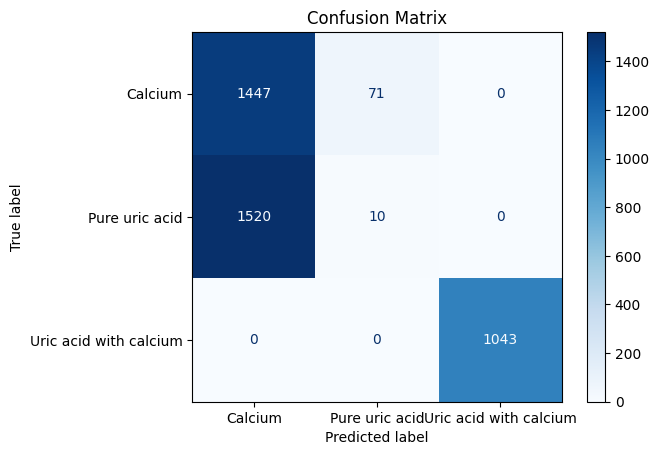

In [ ]:


cm = confusion_matrix(test_df['y'], test_df["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=list(le.classes_))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cm 

array([[1447,   71,    0],
       [1520,   10,    0],
       [   0,    0, 1043]])

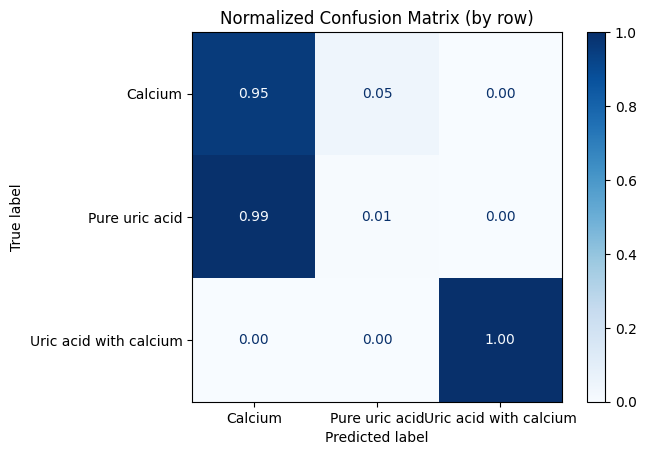

Normalized CM (row-wise):
[[0.953 0.047 0.   ]
 [0.993 0.007 0.   ]
 [0.    0.    1.   ]]


In [ ]:

# Нормируем матрицу по строкам (верные метки)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Создаем визуализацию с частотами
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized,
    display_labels=list(le.classes_)
)

# Настраиваем формат отображения (два знака после запятой)
disp.plot(cmap='Blues', values_format='.2f')  # Используйте '.1%' для процентов

plt.title('Normalized Confusion Matrix (by row)')
plt.show()

# Выводим числовое представление матрицы (опционально)
print("Normalized CM (row-wise):")
print(np.round(cm_normalized, 3))

In [ ]:


print(classification_report(
    test_df['y'],
    test_df['y_pred'],
    target_names=list(le.classes_)
))

                        precision    recall  f1-score   support

               Calcium       0.49      0.95      0.65      1518
        Pure uric acid       0.12      0.01      0.01      1530
Uric acid with calcium       1.00      1.00      1.00      1043

              accuracy                           0.61      4091
             macro avg       0.54      0.65      0.55      4091
          weighted avg       0.48      0.61      0.50      4091



In [ ]:
test_df

,0,1,y,y_pred
0,5.881050,-3.933799,2,2
1,5.882668,-3.919159,2,2
2,5.875584,-3.903661,2,2
3,5.891967,-3.921219,2,2
4,5.904438,-3.922588,2,2
...,...,...,...,...
4086,-1.738062,0.996903,0,0
4087,-1.754919,1.018517,0,0
4088,-1.887003,0.684311,0,0
4089,-1.851615,0.730156,0,0


In [ ]:
probs = model.predict_proba(X_test_pls)
probs

array([[0.00485919, 0.00492139, 0.99021942],
       [0.00487249, 0.00500609, 0.99012141],
       [0.00494138, 0.00510826, 0.98995036],
       ...,
       [0.9788886 , 0.01897979, 0.0021316 ],
       [0.97736229, 0.02044508, 0.00219263],
       [0.96913348, 0.02850742, 0.0023591 ]], shape=(4091, 3))

In [ ]:
probs_df = pd.DataFrame(probs)
probs_df

,0,1,2
0,0.004859,0.004921,0.990219
1,0.004872,0.005006,0.990121
2,0.004941,0.005108,0.989950
3,0.004812,0.004983,0.990205
4,0.004735,0.004959,0.990306
...,...,...,...
4086,0.969017,0.028685,0.002298
4087,0.969039,0.028728,0.002233
4088,0.978889,0.018980,0.002132
4089,0.977362,0.020445,0.002193


In [ ]:
test_df["prob_Calcium"] = probs_df[0]
test_df["prob_Cystine"] = probs_df[1]
test_df["prob_Uric acid"] = probs_df[2]
test_df["prob_Uric acid calcium"] = probs_df[3]

KeyError: 3

In [ ]:
le.classes_

array(['Calcium', 'Cystine', 'Pure uric acid', 'Uric acid with calcium'],
      dtype=object)

IndexError: index 3 is out of bounds for axis 1 with size 3

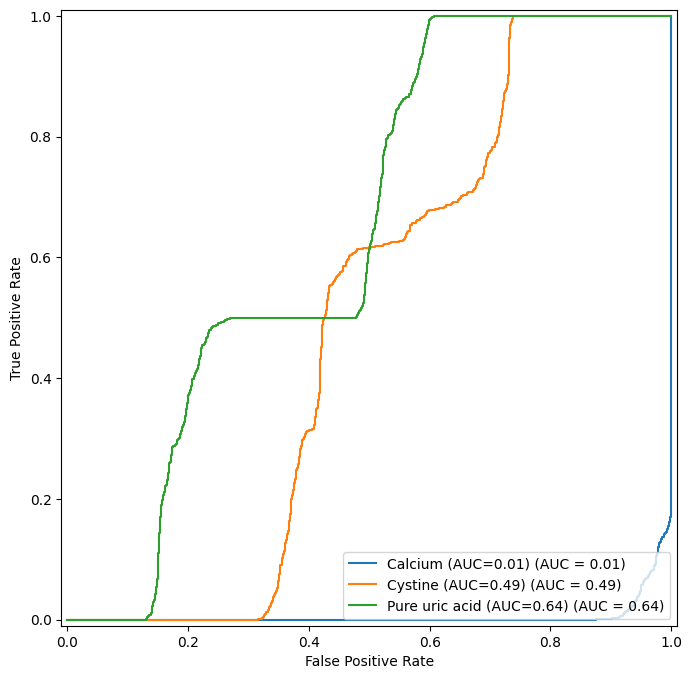

In [ ]:


# Преобразуем метки в one-hot encoding
y_true = label_binarize(test_df['y'], classes=[0,1,2,])
y_score = test_df[['prob_Calcium', "prob_Cystine",
                   'prob_Uric acid', 'prob_Uric acid calcium']].values

fig, ax = plt.subplots(figsize=(10, 8))

# Создадим словарь для хранения AUC значений
auc_scores = {}

for i, cls in enumerate(le.classes_):
    # Вычисляем ROC кривую и AUC
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores[cls] = roc_auc
    
    # Строим кривую с подписью (включая AUC)
    RocCurveDisplay(
        fpr=fpr,
        tpr=tpr,
        roc_auc=roc_auc,
        estimator_name=f"{cls} (AUC={roc_auc:.2f})"
    ).plot(ax=ax)

# Добавляем диагональ (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.50)")

ax.set_title("ROC Curves per Class")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc='lower right')  # Лучшее расположение для ROC
ax.grid()
plt.show()

# Дополнительно: выведем AUC значения
print("AUC Scores:")
for cls, score in auc_scores.items():
    print(f"{cls}: {score:.4f}")

In [ ]:

n_classes = len(le.classes_)
y_test = test_df['y']
y_bin = label_binarize(y_test, classes=np.arange(n_classes))
# Macro-average AUC
macro_auc = roc_auc_score(y_bin, probs, average='macro')
print(f"Macro-average ROC AUC: {macro_auc:.4f}")

# Micro-average AUC
micro_auc = roc_auc_score(y_bin, probs, average='micro')
print(f"Micro-average ROC AUC: {micro_auc:.4f}")

Macro-average ROC AUC: 0.2646
Micro-average ROC AUC: 0.3196


In [ ]:
test_df.to_excel("LDA_compressed_data_test_metrics.xlsx")